## 1. 匯入所需套件

In [1]:
# Import some useful packages
import matplotlib.pyplot as plt
import numpy as np
from ipywidgets import interact, IntSlider, FloatSlider

import tensorflow as tf
import tensorflow.keras.backend as K

# Layers for FNN
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Lambda, concatenate
from tensorflow.keras.layers import Dense

# Optimizers for training
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras import metrics

# Losses for training
from tensorflow.keras import losses

# For data preprocessing
from tensorflow.keras import datasets
from tensorflow.keras.utils import to_categorical

## 2. 下載整理mnist資料

In [2]:
(X_train, y_train0), (X_test, y_test0) = datasets.mnist.load_data()

# Reshape and Normalize
X_train = X_train.reshape(-1, 28*28) / X_train.max()
X_test = X_test.reshape(-1, 28*28) / X_test.max()

# One-hot encoding
y_train = to_categorical(y_train0, 10)
y_test = to_categorical(y_test0, 10)

## 3. 建立VAE模型
* Encoder_layer = 5
* Decoder_layer = 3

In [3]:
# Encoder_layer
enc_1 = Dense(256, activation = 'relu')
enc_2 = Dense(128, activation = 'relu')
enc_3 = Dense(64, activation = 'sigmoid')
enc_mean = Dense(2)
enc_log_var = Dense(2)

# Define Encoder part of VAE
x = Input(shape=(784,))
enc_x = enc_3(enc_2(enc_1(x)))
z_mean = enc_mean(enc_x)
z_log_var = enc_log_var(enc_x)

# Decoder_layer
dec_3 = Dense(128, activation = 'relu')
dec_2 = Dense(256, activation = 'relu')
dec_1 = Dense(784, activation = 'sigmoid')

# Define Decoder part of VAE
z_input = Input(shape=(2,))
x_hat = dec_1(dec_2(dec_3(z_input)))

In [4]:
# sampling

def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape = (batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [5]:
# Sampling function wrapped as a Keras layer
z = Lambda(sampling, output_shape = (2,))([z_mean, z_log_var])

In [6]:
x_hat = dec_1(dec_2(dec_3(z)))

VAE = Model(x, x_hat)
VAE.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 784)]        0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 256)          200960      input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 128)          32896       dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 64)           8256        dense_1[0][0]                    
______________________________________________________________________________________________

## 4. 建立loss函數

In [7]:
# reconstruction_loss = tf.keras.losses.mse(inputs, outputs)
reconstruction_loss = 784 * losses.mean_squared_error(x, x_hat)

kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis = 1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)

VAE.add_loss(vae_loss)

## 5. 訓練VAE模型

In [8]:
VAE.compile(optimizer = Adam())
VAE.fit(X_train, batch_size = 512, epochs = 50)

Epoch 1/50
118/118 [==============================] - 2s 19ms/step - loss: 71.4127 0s - los
Epoch 2/50
118/118 [==============================] - 2s 19ms/step - loss: 52.8492
Epoch 3/50
118/118 [==============================] - 2s 20ms/step - loss: 49.2361
Epoch 4/50
118/118 [==============================] - 2s 19ms/step - loss: 47.3481
Epoch 5/50
118/118 [==============================] - 3s 22ms/step - loss: 45.2185
Epoch 6/50
118/118 [==============================] - 3s 25ms/step - loss: 43.7457 1s - loss: - E
Epoch 7/50
118/118 [==============================] - 3s 22ms/step - loss: 42.7338
Epoch 8/50
118/118 [==============================] - 2s 20ms/step - loss: 41.9287
Epoch 9/50
118/118 [==============================] - 3s 29ms/step - loss: 41.3175
Epoch 10/50
118/118 [==============================] - 4s 34ms/step - loss: 40.8224
Epoch 11/50
118/118 [==============================] - 3s 28ms/step - loss: 40.3378
Epoch 12/50
118/118 [==============================] - 3s 25m

## 6. VAE視覺化

### Encoder視覺化

In [9]:
VAE_Encoder = Model(x, z_mean)
VAE_Encoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense (Dense)                (None, 256)               200960    
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 130       
Total params: 242,242
Trainable params: 242,242
Non-trainable params: 0
_________________________________________________________________


In [10]:
indices = np.random.randint(X_train.shape[0], size = 4000)
VAE_latents = VAE_Encoder.predict(X_train[indices])

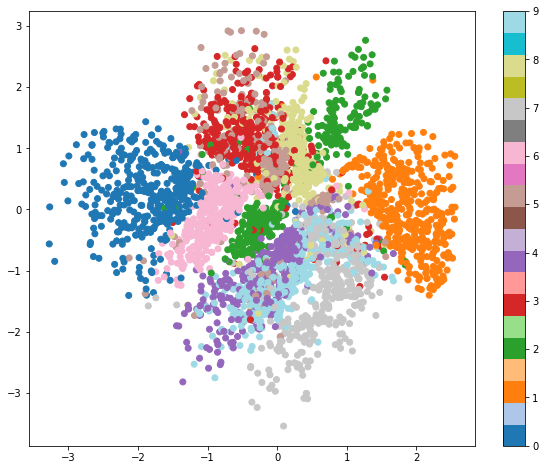

In [11]:
plt.figure(figsize = (10, 8))
plt.scatter(VAE_latents[:, 0], VAE_latents[:, 1], c = y_train0[indices], cmap = 'tab20')
plt.colorbar()
plt.show()

### Decoder視覺化

In [16]:
VAE_Decoder = Model(z_input, dec_1(dec_2(dec_3(z_input))))
VAE_Decoder.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               384       
_________________________________________________________________
dense_6 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_7 (Dense)              (None, 784)               201488    
Total params: 234,896
Trainable params: 234,896
Non-trainable params: 0
_________________________________________________________________


In [17]:
def normalized(x):
    x -= x.min()
    x /= x.max()
    return x

In [18]:
n = 15
digit_size = 28
grid_x_vae = np.linspace(-4+0.05, 4-0.05, n)
grid_y_vae = np.linspace(-4+0.05, 4-0.05, n)
VAE_figure = np.zeros((digit_size * n, digit_size * n))
for i, yi in enumerate(grid_x_vae):
    for j, xi in enumerate(grid_y_vae):
        z_sample = np.array([[xi, yi]])
        x_decoded = VAE_Decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        VAE_figure[(n-i-1) * digit_size: (n - i) * digit_size, j * digit_size: (j + 1) * digit_size] = normalized(digit)

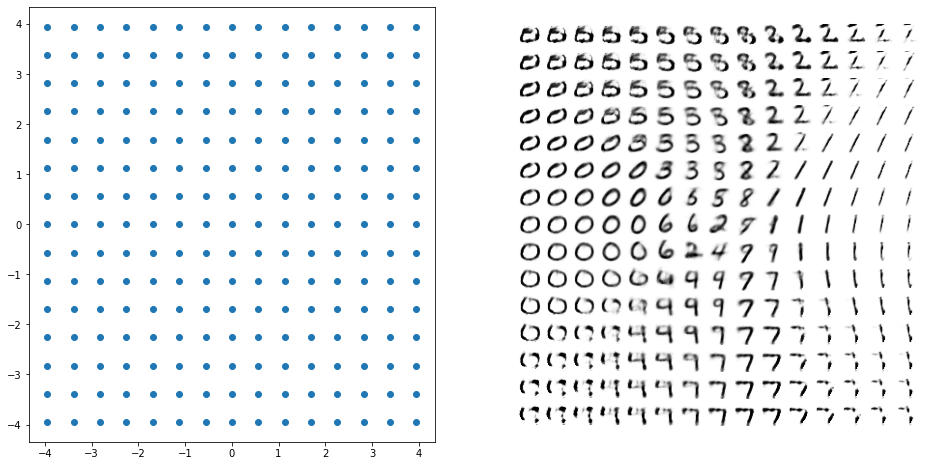

In [19]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
XXX, YYY = np.meshgrid(grid_x_vae, grid_y_vae)
plt.scatter(XXX, YYY)

plt.subplot(1, 2, 2)
plt.imshow(VAE_figure, cmap='Greys')
plt.axis('off')
plt.show()

## 7. 動態比較

In [20]:
idx_1, idx_2 = np.random.randint(X_train.shape[0], size=2)

In [22]:
def inBetween(t):
    data_0 = X_train[idx_1].reshape(28, 28)
    data_1 = X_train[idx_2].reshape(28, 28)
    data_t = (1-t)*data_0 + t*data_1
    
    mu_0 = VAE_Encoder.predict(X_train[idx_1:idx_1+1]).squeeze()
    mu_1 = VAE_Encoder.predict(X_train[idx_2:idx_2+1]).squeeze()
    mu_t = (1-t)*mu_0 + t*mu_1

    plt.figure(figsize=(10, 5))
    ax1 = plt.subplot(2, 1, 2)
    ax1.scatter(mu_0[0], mu_0[1])
    ax1.scatter(mu_1[0], mu_1[1])
    ax1.scatter(mu_t[0], mu_t[1])

    ax2 = plt.subplot(2, 3, 1)
    ax2.imshow(data_0, cmap='Greys')
    ax2.set_title('t=0')

    ax3 = plt.subplot(2, 3, 2)
    ax3.imshow(data_t, cmap='Greys')
    ax3.set_title(f't={t}')

    ax4 = plt.subplot(2, 3, 3)
    ax4.imshow(data_1, cmap='Greys')
    ax4.set_title('t=1')

In [23]:
interact(inBetween, t=FloatSlider(value=0, 
                                  min=0, 
                                  max=1.0,
                                  step=0.02,))

interactive(children=(FloatSlider(value=0.0, description='t', max=1.0, step=0.02), Output()), _dom_classes=('w…

<function __main__.inBetween(t)>